In [1]:
# Display settings
import warnings
warnings.filterwarnings('ignore')

# My dear old friends
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
from numpy import where
from numpy import mean

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Database libraries
import sqlalchemy as db
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, Integer, Table, Column, MetaData

import math
from collections import Counter

# Machine learning libraries
# loading linear algorithms
from sklearn.linear_model import LogisticRegression

# tree based algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# machine learning processing and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import pickle 

In [2]:
# Create SQLite db
restaurants_db = "restaurants.sqlite"
connector = (f"sqlite:///{restaurants_db}")

# Create engine
engine = create_engine(connector)

# Create metadata access to the object
meta_data = db.MetaData(bind=engine)
db.MetaData.reflect(meta_data)

# # Get the tables from the metadata object
# attributes = meta_data.tables["RestaurantAttributes"]
# restaurants = meta_data.tables["Restaurants"]


In [3]:
# Select data into dataframe
sql_join = r"select RestaurantAttributes.*,stars, latitude, longitude from RestaurantAttributes inner join Restaurants on RestaurantAttributes.business_id = Restaurants.business_id"

restaurants_df = pd.read_sql(sql_join, engine)

# Hang onto business_id for later, just in case
business_id_df = restaurants_df["business_id"]
restaurants_df.pop("business_id")

# Don't need change_date
restaurants_df.pop("change_date")

restaurants_df.head()

,ByAppointmentOnly,BusinessAcceptsCreditCards,GoodForKids,WheelchairAccessible,BikeParking,Alcohol,HasTV,NoiseLevel,Caters,WiFi,HappyHour,GoodForDancing,OutdoorSeating,CoatCheck,Smoking,DriveThru,BYOBCorkage,BusinessParkingTypeId,BusinessParkingType,MusicTypeId,MusicType,RestaurantsTypeId,RestaurantsType,GoodForMealTypeId,GoodForMealType,DietaryRestrictionsTypeId,DietaryRestrictionsType,BestNightsTypeId,BestNightsType,AlcoholId,NoiseLevelId,WiFiId,SmokingId,BYOBCorkageId,stars,latitude,longitude
0,0,0,0,1,0,no,0,no,0,no,0,0,0,0,no,0,no,4,BusinessParkinglot,0,na,0,na,0,na,0,na,0,na,1,1,1,1,1,4.5,40.241548,-80.212815
1,0,0,0,0,0,no,0,no,0,no,0,0,0,0,no,0,no,2,BusinessParkingstreet,0,na,0,na,0,na,0,na,0,na,1,1,1,1,1,3.0,43.711399,-79.399339
2,0,0,0,0,0,no,0,no,0,no,0,0,0,0,no,0,no,0,na,0,na,2,RestaurantsGoodForGroups,0,na,0,na,0,na,1,1,1,1,1,3.5,35.047287,-80.990559
3,0,0,1,0,0,no,0,no,0,no,0,0,0,0,no,0,no,0,na,0,na,0,na,0,na,0,na,0,na,1,1,1,1,1,3.0,45.506772,-73.566725
4,0,0,0,1,0,no,0,no,0,no,0,0,0,0,no,0,no,4,BusinessParkinglot,0,na,0,na,0,na,0,na,0,na,1,1,1,1,1,3.5,40.041003,-75.542497


In [4]:
for col in restaurants_df:
#     print(f"Name: {col} | Values: {restaurants_df[col].unique()}")
    print(f"Value counts for {col}: \n{restaurants_df[col].value_counts()}")

# Most values are "Na" or "No" and only a handful have actual values selected. This portends evil...

Value counts for ByAppointmentOnly: 
0    13846
1        2
Name: ByAppointmentOnly, dtype: int64
Value counts for BusinessAcceptsCreditCards: 
0    13824
1       24
Name: BusinessAcceptsCreditCards, dtype: int64
Value counts for GoodForKids: 
0    10201
1     3647
Name: GoodForKids, dtype: int64
Value counts for WheelchairAccessible: 
0    9175
1    4673
Name: WheelchairAccessible, dtype: int64
Value counts for BikeParking: 
0    13826
1       22
Name: BikeParking, dtype: int64
Value counts for Alcohol: 
no               13379
full_bar           354
none                75
beer_and_wine       40
Name: Alcohol, dtype: int64
Value counts for HasTV: 
0    13821
1       27
Name: HasTV, dtype: int64
Value counts for NoiseLevel: 
no         13828
average       12
loud           4
quiet          4
Name: NoiseLevel, dtype: int64
Value counts for Caters: 
0    13839
1        9
Name: Caters, dtype: int64
Value counts for WiFi: 
no      13843
free        3
paid        2
Name: WiFi, dtype: int64
Va

In [5]:
# drop string cols - they're already encoded in the id cols
string_cols = restaurants_df.select_dtypes(include=["object"]).columns.tolist()
string_cols

restaurants_df.drop(string_cols, axis=1, inplace=True)
restaurants_df.dtypes

ByAppointmentOnly               int64
BusinessAcceptsCreditCards      int64
GoodForKids                     int64
WheelchairAccessible            int64
BikeParking                     int64
HasTV                           int64
Caters                          int64
HappyHour                       int64
GoodForDancing                  int64
OutdoorSeating                  int64
CoatCheck                       int64
DriveThru                       int64
BusinessParkingTypeId           int64
MusicTypeId                     int64
RestaurantsTypeId               int64
GoodForMealTypeId               int64
DietaryRestrictionsTypeId       int64
BestNightsTypeId                int64
AlcoholId                       int64
NoiseLevelId                    int64
WiFiId                          int64
SmokingId                       int64
BYOBCorkageId                   int64
stars                         float64
latitude                      float64
longitude                     float64
dtype: objec

In [6]:
print(restaurants_df.stars.value_counts())
restaurants_df.stars.describe()

3.5    3581
4.0    3194
3.0    2950
2.5    1485
4.5    1363
2.0     678
5.0     333
1.5     209
1.0      55
Name: stars, dtype: int64


count    13848.000000
mean         3.422516
std          0.748382
min          1.000000
25%          3.000000
50%          3.500000
75%          4.000000
max          5.000000
Name: stars, dtype: float64

3.5    3581
4.0    3194
3.0    2950
2.5    1485
4.5    1363
2.0     678
5.0     333
1.5     209
1.0      55
Name: stars, dtype: int64


<AxesSubplot:ylabel='Density'>

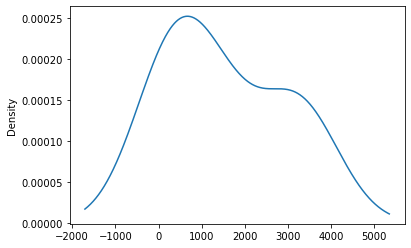

In [7]:
# Visualize the value counts of stars
stars_counts = restaurants_df.stars.value_counts()
print(stars_counts)

stars_counts.plot.density()

4    6775
3    4435
5    1696
2     887
Name: stars, dtype: int64


<AxesSubplot:ylabel='Density'>

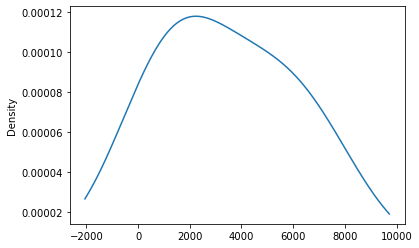

In [8]:
# convert stars to categories
model_df = restaurants_df.copy()

# Rounding didn't help - lets try binary classes
# # Round the target column and convert to integer for processing; being generous and rounding favorably!
# model_df['stars'] = model_df['stars'].apply(np.ceil).astype(int)

# # Drop 1* reviews as there arent enough of them to make a difference
# model_df.drop(model_df.loc[model_df.stars == 1].index, inplace=True)

# rounded_counts = model_df.stars.value_counts()
# print(rounded_counts)

# rounded_counts.plot.density()

# This was a terrible tragedy... switching back to rounding, will drop 2* reviews as well and see what happens
# model_df.loc[model_df["stars"] < 4] = 0
# model_df.loc[model_df["stars"] >= 4] = 1

# model_df.head()

# Round the target column and convert to integer for processing; being generous and rounding favorably!
model_df['stars'] = model_df['stars'].apply(np.ceil).astype(int)

# # Drop 1 and 2* reviews as there arent enough of them to make a difference
# model_df.drop(model_df.loc[model_df.stars <= 2].index, inplace=True)

# Drop 1* reviews as there arent enough of them to make a difference
model_df.drop(model_df.loc[model_df.stars <= 1].index, inplace=True)

rounded_counts = model_df.stars.value_counts()
print(rounded_counts)

rounded_counts.plot.density()


In [9]:
corrs = abs(model_df.corr())["stars"].sort_values(ascending=False)
corrs

# No data point has a direct correlation to the stars

stars                         1.000000
DriveThru                     0.067417
longitude                     0.044939
GoodForMealTypeId             0.039831
BusinessParkingTypeId         0.039066
GoodForKids                   0.035261
latitude                      0.023214
NoiseLevelId                  0.021447
HappyHour                     0.017195
SmokingId                     0.016248
BikeParking                   0.014603
HasTV                         0.013115
ByAppointmentOnly             0.012918
BYOBCorkageId                 0.012410
DietaryRestrictionsTypeId     0.012166
CoatCheck                     0.009338
Caters                        0.007160
BestNightsTypeId              0.005330
AlcoholId                     0.004512
BusinessAcceptsCreditCards    0.004179
OutdoorSeating                0.004130
RestaurantsTypeId             0.003319
WiFiId                        0.002363
WheelchairAccessible          0.002193
GoodForDancing                0.000477
MusicTypeId              

In [10]:
model_df.info()

# No nulls, the only string is the business_id; stars is still a float and needs to be categorized

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13793 entries, 0 to 13847
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ByAppointmentOnly           13793 non-null  int64  
 1   BusinessAcceptsCreditCards  13793 non-null  int64  
 2   GoodForKids                 13793 non-null  int64  
 3   WheelchairAccessible        13793 non-null  int64  
 4   BikeParking                 13793 non-null  int64  
 5   HasTV                       13793 non-null  int64  
 6   Caters                      13793 non-null  int64  
 7   HappyHour                   13793 non-null  int64  
 8   GoodForDancing              13793 non-null  int64  
 9   OutdoorSeating              13793 non-null  int64  
 10  CoatCheck                   13793 non-null  int64  
 11  DriveThru                   13793 non-null  int64  
 12  BusinessParkingTypeId       13793 non-null  int64  
 13  MusicTypeId                 137

In [11]:
target = ["stars"]

columns = model_df.columns.values.tolist()
columns.remove(target[0])

columns

['ByAppointmentOnly',
 'BusinessAcceptsCreditCards',
 'GoodForKids',
 'WheelchairAccessible',
 'BikeParking',
 'HasTV',
 'Caters',
 'HappyHour',
 'GoodForDancing',
 'OutdoorSeating',
 'CoatCheck',
 'DriveThru',
 'BusinessParkingTypeId',
 'MusicTypeId',
 'RestaurantsTypeId',
 'GoodForMealTypeId',
 'DietaryRestrictionsTypeId',
 'BestNightsTypeId',
 'AlcoholId',
 'NoiseLevelId',
 'WiFiId',
 'SmokingId',
 'BYOBCorkageId',
 'latitude',
 'longitude']

In [12]:
model_df.head()

,ByAppointmentOnly,BusinessAcceptsCreditCards,GoodForKids,WheelchairAccessible,BikeParking,HasTV,Caters,HappyHour,GoodForDancing,OutdoorSeating,CoatCheck,DriveThru,BusinessParkingTypeId,MusicTypeId,RestaurantsTypeId,GoodForMealTypeId,DietaryRestrictionsTypeId,BestNightsTypeId,AlcoholId,NoiseLevelId,WiFiId,SmokingId,BYOBCorkageId,stars,latitude,longitude
0,0,0,0,1,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,1,1,1,1,5,40.241548,-80.212815
1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,1,1,1,3,43.711399,-79.399339
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,1,1,1,4,35.047287,-80.990559
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,3,45.506772,-73.566725
4,0,0,0,1,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,1,1,1,1,4,40.041003,-75.542497


In [13]:
correlations = restaurants_df.corr()
correlations

,ByAppointmentOnly,BusinessAcceptsCreditCards,GoodForKids,WheelchairAccessible,BikeParking,HasTV,Caters,HappyHour,GoodForDancing,OutdoorSeating,CoatCheck,DriveThru,BusinessParkingTypeId,MusicTypeId,RestaurantsTypeId,GoodForMealTypeId,DietaryRestrictionsTypeId,BestNightsTypeId,AlcoholId,NoiseLevelId,WiFiId,SmokingId,BYOBCorkageId,stars,latitude,longitude
ByAppointmentOnly,1.000000,-0.000501,-0.007186,-0.008577,-0.000479,-0.000531,-0.000306,-0.000457,-0.000766,-0.000723,-0.000204,-0.001090,-0.009117,-0.000137,-0.003287,-0.001575,-0.000436,-0.000209,-0.002030,-0.000409,-0.000216,-0.001006,-0.000531,0.017304,-0.010884,-0.011359
BusinessAcceptsCreditCards,-0.000501,1.000000,-0.024914,-0.029736,-0.001662,-0.001842,-0.001063,-0.001585,-0.002655,-0.002508,-0.000708,-0.003779,-0.025705,-0.000475,-0.011396,-0.005459,-0.001511,-0.000723,-0.007037,-0.001417,-0.000747,-0.003488,-0.001842,0.007794,0.005995,0.002373
GoodForKids,-0.007186,-0.024914,1.000000,-0.426718,-0.023851,-0.026428,-0.015248,-0.022740,-0.038100,-0.035993,-0.010164,-0.054234,-0.057617,-0.006817,-0.163530,-0.078334,-0.021681,-0.010380,-0.100978,-0.020336,-0.010726,-0.050056,-0.026428,0.039343,0.063823,0.024818
WheelchairAccessible,-0.008577,-0.029736,-0.426718,1.000000,-0.028468,-0.031543,-0.018200,-0.027141,-0.045475,-0.042961,-0.012131,-0.064732,0.356591,-0.008137,-0.195185,-0.093497,-0.016623,-0.012390,-0.120524,-0.024272,-0.012802,-0.059745,-0.031543,0.006751,-0.209693,-0.174730
BikeParking,-0.000479,-0.001662,-0.023851,-0.028468,1.000000,-0.001763,-0.001017,-0.001517,-0.002542,-0.002401,-0.000678,-0.003618,-0.030260,-0.000455,-0.010910,-0.005226,-0.001446,-0.000693,-0.006737,-0.001357,-0.000716,-0.003339,-0.001763,0.013822,0.007952,-0.001173
HasTV,-0.000531,-0.001842,-0.026428,-0.031543,-0.001763,1.000000,-0.001127,-0.001681,-0.002816,-0.002661,-0.000751,-0.004009,-0.033529,-0.000504,-0.012088,-0.005790,-0.001603,-0.000767,-0.007464,-0.001503,-0.000793,-0.003700,-0.001954,-0.010736,0.014741,0.003409
Caters,-0.000306,-0.001063,-0.015248,-0.018200,-0.001017,-0.001127,1.000000,-0.000970,-0.001625,-0.001535,-0.000433,-0.002313,-0.019346,-0.000291,-0.006975,-0.003341,-0.000925,-0.000443,-0.004307,-0.000867,-0.000457,-0.002135,-0.001127,0.010213,0.003466,0.002261
HappyHour,-0.000457,-0.001585,-0.022740,-0.027141,-0.001517,-0.001681,-0.000970,1.000000,-0.002423,-0.002289,-0.000646,-0.003450,-0.024540,-0.000434,-0.010401,-0.004982,-0.001379,-0.000660,-0.006423,-0.001293,-0.000682,-0.003184,-0.001681,-0.021472,-0.000257,0.004791
GoodForDancing,-0.000766,-0.002655,-0.038100,-0.045475,-0.002542,-0.002816,-0.001625,-0.002423,1.000000,-0.003836,-0.001083,-0.005780,-0.021257,-0.000727,-0.017427,-0.008348,-0.002311,-0.001106,-0.010761,-0.002167,-0.001143,-0.005334,-0.002816,0.002036,0.013303,0.004422
OutdoorSeating,-0.000723,-0.002508,-0.035993,-0.042961,-0.002401,-0.002661,-0.001535,-0.002289,-0.003836,1.000000,-0.001023,-0.005460,-0.045666,-0.000686,-0.016464,-0.007886,-0.002183,-0.001045,-0.010166,-0.002047,-0.001080,-0.005039,-0.002661,0.000602,0.023443,0.047100


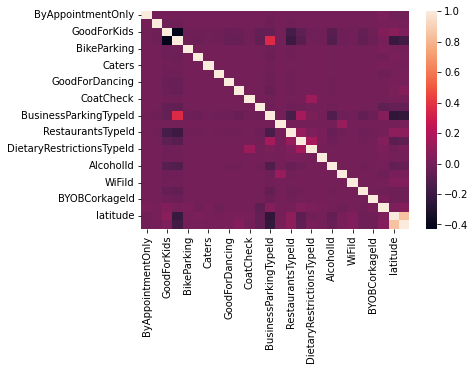

In [14]:
sns.heatmap(correlations)
plt.show()

In [15]:
def evaluateModel(model, X_train, y_train, X_test, y_test):
    # FIT THE MODEL
    model.fit(X_train, y_train)

    # EVALUATE the MODEL
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # PRINT the METRICS
    print("TRAINING SET")

    class_report_train = classification_report(y_train, train_preds)
    conf_matrix_train = confusion_matrix(y_train, train_preds)

    print(class_report_train)
    print(conf_matrix_train)

    print()

    # PRINT the METRICS
    print("Testing SET")

    class_report_test = classification_report(y_test, test_preds)
    conf_matrix_test = confusion_matrix(y_test, test_preds)

    print(class_report_test)
    print(conf_matrix_test)
    
# Can't build ROC curve on multicategorical data set    
#     # Creates the Roc Curve
#     y_pred_proba = model.predict_proba(X_test)[::,1]
#     fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
#     auc = roc_auc_score(y_test, y_pred_proba)

#     plt.figure(figsize=(10,6))
#     plt.plot(fpr,tpr,label="auc="+str(auc))
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title("ROC Curve Test Set")
#     plt.legend(loc=4)
#     plt.show()
    
    return(model)

In [16]:
 # get data
X = model_df[columns]
y = model_df[target]
y

,stars
0,5
1,3
2,4
3,3
4,4
...,...
13843,3
13844,4
13845,5
13846,4


In [17]:
# Use the Sklearn `train_test_split()` function to split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25, stratify=y)

print(len(X_train) / len(X))
print(len(X_test) / len(X))

0.7499456245921844
0.25005437540781555


In [18]:
# XGBoost Regression
xgb = XGBClassifier(random_state=42)
xgb = evaluateModel(xgb, X_train, y_train, X_test, y_test)

TRAINING SET
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       665
           3       0.56      0.15      0.24      3326
           4       0.52      0.96      0.67      5081
           5       0.88      0.01      0.01      1272

    accuracy                           0.52     10344
   macro avg       0.49      0.28      0.23     10344
weighted avg       0.54      0.52      0.41     10344

[[   0  100  565    0]
 [   0  515 2810    1]
 [   0  227 4854    0]
 [   0   73 1192    7]]

Testing SET
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       222
           3       0.39      0.11      0.17      1109
           4       0.50      0.93      0.65      1694
           5       0.00      0.00      0.00       424

    accuracy                           0.49      3449
   macro avg       0.22      0.26      0.20      3449
weighted avg       0.37      0.49      0.37      3449

[[   0   38

In [19]:
# Scale pos weight formula = (row count - count of least populous class) / count of least populous class; value is 14.5 
# XGBoost Regression
xgb = XGBClassifier(random_state=42, scale_pos_weight=14)
xgb = evaluateModel(xgb, X_train, y_train, X_test, y_test)

TRAINING SET
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       665
           3       0.56      0.15      0.24      3326
           4       0.52      0.96      0.67      5081
           5       0.88      0.01      0.01      1272

    accuracy                           0.52     10344
   macro avg       0.49      0.28      0.23     10344
weighted avg       0.54      0.52      0.41     10344

[[   0  100  565    0]
 [   0  515 2810    1]
 [   0  227 4854    0]
 [   0   73 1192    7]]

Testing SET
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       222
           3       0.39      0.11      0.17      1109
           4       0.50      0.93      0.65      1694
           5       0.00      0.00      0.00       424

    accuracy                           0.49      3449
   macro avg       0.22      0.26      0.20      3449
weighted avg       0.37      0.49      0.37      3449

[[   0   38

In [20]:
# Scale pos weight formula = (row count - count of least populous class) / count of least populous class; value is 14.5 
# XGBoost Regression
xgb = XGBClassifier(random_state=42, scale_pos_weight=15)
xgb = evaluateModel(xgb, X_train, y_train, X_test, y_test)

TRAINING SET
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       665
           3       0.56      0.15      0.24      3326
           4       0.52      0.96      0.67      5081
           5       0.88      0.01      0.01      1272

    accuracy                           0.52     10344
   macro avg       0.49      0.28      0.23     10344
weighted avg       0.54      0.52      0.41     10344

[[   0  100  565    0]
 [   0  515 2810    1]
 [   0  227 4854    0]
 [   0   73 1192    7]]

Testing SET
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       222
           3       0.39      0.11      0.17      1109
           4       0.50      0.93      0.65      1694
           5       0.00      0.00      0.00       424

    accuracy                           0.49      3449
   macro avg       0.22      0.26      0.20      3449
weighted avg       0.37      0.49      0.37      3449

[[   0   38

In [21]:
y_probs = y.copy()
y_probs.head(20)

,stars
0,5
1,3
2,4
3,3
4,4
5,4
6,2
7,3
8,2
9,3


In [22]:
y_probs["probability_class_2"] = xgb.predict_proba(X)[:, 0]
y_probs["probability_class_3"] = xgb.predict_proba(X)[:, 1]
y_probs["probability_class_4"] = xgb.predict_proba(X)[:, 2]
y_probs["probability_class_5"] = xgb.predict_proba(X)[:, 3]
y_probs

,stars,probability_class_2,probability_class_3,probability_class_4,probability_class_5
0,5,0.039829,0.359153,0.476823,0.124195
1,3,0.042869,0.363343,0.512572,0.081217
2,4,0.090223,0.340000,0.396107,0.173670
3,3,0.036184,0.284963,0.540926,0.137928
4,4,0.037773,0.353099,0.480838,0.128290
...,...,...,...,...,...
13843,3,0.081972,0.326327,0.421966,0.169735
13844,4,0.085806,0.352532,0.434351,0.127310
13845,5,0.064624,0.184206,0.534578,0.216592
13846,4,0.083168,0.368431,0.466698,0.081703


In [23]:
# sum(2proba*2 + 3proba*3 + 4proba*4 + 5proba*5)
y_probs["rating"] = (y_probs["probability_class_2"]*2) + (y_probs["probability_class_3"]*3) + (y_probs["probability_class_4"]*4) + (y_probs["probability_class_5"]*5)
y_probs

,stars,probability_class_2,probability_class_3,probability_class_4,probability_class_5,rating
0,5,0.039829,0.359153,0.476823,0.124195,3.685384
1,3,0.042869,0.363343,0.512572,0.081217,3.632137
2,4,0.090223,0.340000,0.396107,0.173670,3.653224
3,3,0.036184,0.284963,0.540926,0.137928,3.780597
4,4,0.037773,0.353099,0.480838,0.128290,3.699645
...,...,...,...,...,...,...
13843,3,0.081972,0.326327,0.421966,0.169735,3.679464
13844,4,0.085806,0.352532,0.434351,0.127310,3.603165
13845,5,0.064624,0.184206,0.534578,0.216592,3.903139
13846,4,0.083168,0.368431,0.466698,0.081703,3.546937


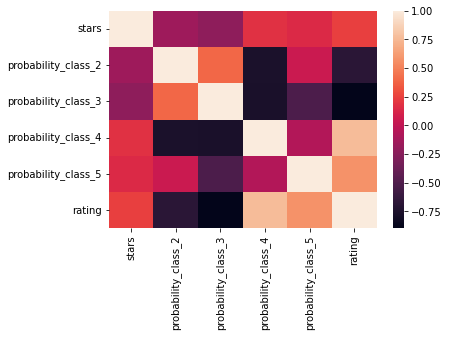

In [24]:
corrs = y_probs.corr()

sns.heatmap(corrs)
plt.show()

In [25]:
corrs

,stars,probability_class_2,probability_class_3,probability_class_4,probability_class_5,rating
stars,1.000000,-0.151995,-0.220725,0.179061,0.145379,0.239255
probability_class_2,-0.151995,1.000000,0.396677,-0.757383,0.045294,-0.685999
probability_class_3,-0.220725,0.396677,1.000000,-0.769356,-0.516082,-0.898134
probability_class_4,0.179061,-0.757383,-0.769356,1.000000,-0.067409,0.764772
probability_class_5,0.145379,0.045294,-0.516082,-0.067409,1.000000,0.571654
rating,0.239255,-0.685999,-0.898134,0.764772,0.571654,1.000000


In [26]:
(y_probs["probability_class_2"]*2) + (y_probs["probability_class_3"]*3) + (y_probs["probability_class_4"]*4) + (y_probs["probability_class_5"]*5)

0        3.685384
1        3.632137
2        3.653224
3        3.780597
4        3.699645
           ...   
13843    3.679464
13844    3.603165
13845    3.903139
13846    3.546937
13847    3.506616
Length: 13793, dtype: float32

In [27]:
# RandomForestClassifier Regression
rfc = RandomForestClassifier(random_state=42)
rfc = evaluateModel(rfc, X_train, y_train, X_test, y_test)

TRAINING SET
              precision    recall  f1-score   support

           2       0.99      0.97      0.98       665
           3       0.99      0.99      0.99      3326
           4       0.99      0.99      0.99      5081
           5       0.99      0.99      0.99      1272

    accuracy                           0.99     10344
   macro avg       0.99      0.99      0.99     10344
weighted avg       0.99      0.99      0.99     10344

[[ 644   10    9    2]
 [   5 3293   25    3]
 [   2   25 5052    2]
 [   0    4   10 1258]]

Testing SET
              precision    recall  f1-score   support

           2       0.13      0.08      0.10       222
           3       0.34      0.34      0.34      1109
           4       0.52      0.58      0.55      1694
           5       0.15      0.11      0.13       424

    accuracy                           0.41      3449
   macro avg       0.28      0.28      0.28      3449
weighted avg       0.39      0.41      0.40      3449

[[ 18  90  

In [28]:
# AdaBoostClassifier Regression
abc = AdaBoostClassifier(random_state=42)
abc = evaluateModel(abc, X_train, y_train, X_test, y_test)

TRAINING SET
              precision    recall  f1-score   support

           2       0.57      0.01      0.01       665
           3       0.46      0.11      0.18      3326
           4       0.50      0.95      0.66      5081
           5       0.40      0.00      0.00      1272

    accuracy                           0.50     10344
   macro avg       0.48      0.27      0.21     10344
weighted avg       0.48      0.50      0.38     10344

[[   4   98  563    0]
 [   0  360 2965    1]
 [   2  273 4804    2]
 [   1   55 1214    2]]

Testing SET
              precision    recall  f1-score   support

           2       1.00      0.00      0.01       222
           3       0.41      0.10      0.17      1109
           4       0.50      0.94      0.65      1694
           5       0.25      0.00      0.00       424

    accuracy                           0.49      3449
   macro avg       0.54      0.26      0.21      3449
weighted avg       0.47      0.49      0.37      3449

[[   1   35

In [29]:
# ExtraTreesClassifier Regression
etc = ExtraTreesClassifier(random_state=42)
etc = evaluateModel(etc, X_train, y_train, X_test, y_test)

TRAINING SET
              precision    recall  f1-score   support

           2       0.96      1.00      0.98       665
           3       0.98      0.99      0.99      3326
           4       1.00      0.99      0.99      5081
           5       1.00      0.98      0.99      1272

    accuracy                           0.99     10344
   macro avg       0.99      0.99      0.99     10344
weighted avg       0.99      0.99      0.99     10344

[[ 663    1    1    0]
 [  14 3309    3    0]
 [   9   47 5025    0]
 [   2    7   12 1251]]

Testing SET
              precision    recall  f1-score   support

           2       0.15      0.13      0.14       222
           3       0.34      0.33      0.33      1109
           4       0.51      0.55      0.53      1694
           5       0.15      0.13      0.14       424

    accuracy                           0.40      3449
   macro avg       0.29      0.28      0.28      3449
weighted avg       0.39      0.40      0.39      3449

[[ 28  91  

In [30]:
# GradientBoostingClassifier Regression
gbc = GradientBoostingClassifier(random_state=42)
gbc = evaluateModel(gbc, X_train, y_train, X_test, y_test)

TRAINING SET
              precision    recall  f1-score   support

           2       0.92      0.04      0.07       665
           3       0.60      0.19      0.29      3326
           4       0.52      0.95      0.68      5081
           5       0.92      0.03      0.07      1272

    accuracy                           0.53     10344
   macro avg       0.74      0.30      0.28     10344
weighted avg       0.62      0.53      0.44     10344

[[  24  102  538    1]
 [   1  637 2687    1]
 [   1  252 4826    2]
 [   0   71 1157   44]]

Testing SET
              precision    recall  f1-score   support

           2       0.57      0.02      0.03       222
           3       0.40      0.13      0.20      1109
           4       0.50      0.91      0.65      1694
           5       0.12      0.00      0.01       424

    accuracy                           0.49      3449
   macro avg       0.40      0.27      0.22      3449
weighted avg       0.43      0.49      0.38      3449

[[   4   42

In [31]:
# LGBMClassifier Regression
lgb = LGBMClassifier(random_state=42)
lgb = evaluateModel(lgb, X_train, y_train, X_test, y_test)

TRAINING SET
              precision    recall  f1-score   support

           2       0.76      0.06      0.12       665
           3       0.61      0.40      0.48      3326
           4       0.58      0.90      0.70      5081
           5       0.75      0.08      0.15      1272

    accuracy                           0.59     10344
   macro avg       0.67      0.36      0.36     10344
weighted avg       0.62      0.59      0.53     10344

[[  42  196  421    6]
 [   6 1325 1981   14]
 [   5  477 4584   15]
 [   2  181  983  106]]

Testing SET
              precision    recall  f1-score   support

           2       0.29      0.02      0.03       222
           3       0.37      0.24      0.29      1109
           4       0.51      0.80      0.62      1694
           5       0.22      0.03      0.05       424

    accuracy                           0.48      3449
   macro avg       0.35      0.27      0.25      3449
weighted avg       0.41      0.48      0.41      3449

[[   4   75

## Model Selection

In [32]:
# Selected GradientBoost because it had the best stats by a small margin.

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(gbc, open(filename, 'wb'))

In [33]:
# CONTENT OPTIONS:
# ByAppointmentOnly: BIT
# BusinessAcceptsCreditCards: BIT
# GoodForKids: BIT
# WheelchairAccessible: BIT
# BikeParking: BIT
# HasTV: BIT
# Caters: BIT
# HappyHour: BIT
# GoodForDancing: BIT
# OutdoorSeating: BIT
# CoatCheck: BIT
# DriveThru: BIT

def convert_bit(input_val):
    if input_val=='False':
        return 0
    elif input_val=='True': 
        return 1
    else: 
        pass
    
# convert_bit("butter")

In [34]:
# CONTENT OPTIONS:
# Alcohol: CATEGORY
# 	no: 1
# 	full_bar: 2
# 	none: 3
# 	beer_and_wine: 4
# NoiseLevel: CATEGORY
# 	no: 1
# 	average: 2
# 	loud: 3
# 	quiet: 4
# WiFi: CATEGORY
# 	no: 1
# 	free: 2
# 	paid: 3
# Smoking: CATEGORY
# 	no: 1
# 	outdoor: 2
# 	yes: 3
# BYOBCorkage: 
# 	no: 1
# 	yes_free: 2
# 	yes_corkage: 3
# BusinessParkingType: CATEGORY
# 	na: 1
# 	BusinessParkinglot: 4
# 	BusinessParkingstreet: 2
# 	BusinessParkinggarage: 1
# 	BusinessParkingvalet: 5
# 	BusinessParkingvalidated: 3
# MusicType: CATEGORY
# 	na: 0
# 	Musicdj: 1
# 	Musickaraoke: 2
# RestaurantsType: CATEGORY
# 	na: 0
# 	RestaurantsGoodForGroups: 2
# 	RestaurantsTakeOut: 4
# 	RestaurantsTableService: 5
# 	RestaurantsDelivery: 6
# 	RestaurantsReservations: 3
# GoodForMealType: CATEGORY
# 	na: 0
# 	GoodForMealdinner: 4
# 	GoodForMeallunch: 3
# 	GoodForMealbrunch: 6
# 	GoodForMealbreakfast: 5
# 	GoodForMealdessert: 1
# 	GoodForMeallatenight: 2
# DietaryRestrictionsType: CATEGORY 
# 	na: 0
# 	DietaryRestrictionsvegetarian: 7
# 	DietaryRestrictionsvegan: 3
# BestNightsType: CATEGORY
# 	na: 0
# 	BestNightssaturday: 6
# 	BestNightsfriday: 2

def convert_id(input_val, category):
    # Select data into dataframe
    sql_stmt = r"select id from " + category + "Type where description == '" + input_val + "';"

    input_val_df = pd.read_sql(sql_stmt, engine)
    return input_val_df["id"][0] if len(input_val_df)>0 else 0

In [35]:
content = {"ByAppointmentOnly": "True",
            "BusinessAcceptsCreditCards": "True",
            "GoodForKids": "True",
            "WheelchairAccessible": "True",
            "BikeParking": "True",
            "HasTV": "True",
            "Caters": "True",
            "HappyHour": "True",
            "GoodForDancing": "True",
            "OutdoorSeating": "True",
            "CoatCheck": "True",
            "DriveThru": "True",
            "Alcohol": "full_bar",
            "NoiseLevel": "average",
            "WiFi": "free",
            "Smoking": "no",
            "BYOBCorkage": "yes_free",
            "BusinessParkingType": "BusinessParkinglot",
            "MusicType": "na",
            "RestaurantsType": "na",
            "GoodForMealType": "na",
            "DietaryRestrictionsType": "na",
            "BestNightsType": "BestNightssaturday",
            "stars": 3,
            "latitude": 1.684984,
            "longitude": 69.654968}
content

{'ByAppointmentOnly': 'True',
 'BusinessAcceptsCreditCards': 'True',
 'GoodForKids': 'True',
 'WheelchairAccessible': 'True',
 'BikeParking': 'True',
 'HasTV': 'True',
 'Caters': 'True',
 'HappyHour': 'True',
 'GoodForDancing': 'True',
 'OutdoorSeating': 'True',
 'CoatCheck': 'True',
 'DriveThru': 'True',
 'Alcohol': 'full_bar',
 'NoiseLevel': 'average',
 'WiFi': 'free',
 'Smoking': 'no',
 'BYOBCorkage': 'yes_free',
 'BusinessParkingType': 'BusinessParkinglot',
 'MusicType': 'na',
 'RestaurantsType': 'na',
 'GoodForMealType': 'na',
 'DietaryRestrictionsType': 'na',
 'BestNightsType': 'BestNightssaturday',
 'stars': 3,
 'latitude': 1.684984,
 'longitude': 69.654968}

In [36]:
# Parse content
ByAppointmentOnly = int(convert_bit(content["ByAppointmentOnly"]))
BusinessAcceptsCreditCards = int(convert_bit(content["BusinessAcceptsCreditCards"]))
GoodForKids = int(convert_bit(content["GoodForKids"]))
WheelchairAccessible = int(convert_bit(content["WheelchairAccessible"]))
BikeParking = int(convert_bit(content["BikeParking"]))
HasTV = int(convert_bit(content["HasTV"]))
Caters = int(convert_bit(content["Caters"]))
HappyHour = int(convert_bit(content["HappyHour"]))
GoodForDancing = int(convert_bit(content["GoodForDancing"]))
OutdoorSeating = int(convert_bit(content["OutdoorSeating"]))
CoatCheck = int(convert_bit(content["CoatCheck"]))
DriveThru = int(convert_bit(content["DriveThru"]))
BusinessParkingTypeId = int(convert_id(content["BusinessParkingType"], "BusinessParking"))
MusicTypeId = int(convert_id(content["MusicType"], "Music"))
RestaurantsTypeId = int(convert_id(content["RestaurantsType"], "Restaurants"))
GoodForMealTypeId = int(convert_id(content["GoodForMealType"], "GoodForMeal"))
DietaryRestrictionsTypeId = int(convert_id(content["DietaryRestrictionsType"], "DietaryRestrictions"))
BestNightsTypeId = int(convert_id(content["BestNightsType"], "BestNights"))
AlcoholId = int(convert_id(content["Alcohol"], "Alcohol"))
NoiseLevelId = int(convert_id(content["NoiseLevel"], "NoiseLevel"))
WiFiId = int(convert_id(content["WiFi"], "WiFi"))
SmokingId = int(convert_id(content["Smoking"], "Smoking"))
BYOBCorkageId = int(convert_id(content["BYOBCorkage"], "BYOBCorkage"))
stars = int(content["stars"])
latitude = float(content["latitude"])
longitude = float(content["longitude"])

In [37]:
prediction_input = [[ByAppointmentOnly,
                     BusinessAcceptsCreditCards,
                     GoodForKids,
                     WheelchairAccessible,
                     BikeParking,
                     HasTV,
                     Caters,
                     HappyHour,
                     GoodForDancing,
                     OutdoorSeating,
                     CoatCheck,
                     DriveThru,
                     BusinessParkingTypeId,
                     MusicTypeId,
                     RestaurantsTypeId,
                     GoodForMealTypeId,
                     DietaryRestrictionsTypeId,
                     BestNightsTypeId,
                     AlcoholId,
                     NoiseLevelId,
                     WiFiId,
                     SmokingId,
                     BYOBCorkageId,
                     latitude,
 longitude]]

prediction_input

[[1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  4,
  0,
  0,
  0,
  0,
  6,
  2,
  2,
  2,
  1,
  2,
  1.684984,
  69.654968]]

In [38]:
df = pd.DataFrame(prediction_input, columns=['ByAppointmentOnly',
                                         'BusinessAcceptsCreditCards',
                                         'GoodForKids',
                                         'WheelchairAccessible',
                                         'BikeParking',
                                         'HasTV',
                                         'Caters',
                                         'HappyHour',
                                         'GoodForDancing',
                                         'OutdoorSeating',                                         
                                         'CoatCheck',
                                         'DriveThru',
                                         'BusinessParkingTypeId',
                                         'MusicTypeId',
                                         'RestaurantsTypeId',
                                         'GoodForMealTypeId',
                                         'DietaryRestrictionsTypeId',
                                         'BestNightsTypeId',
                                         'AlcoholId', 
                                         'NoiseLevelId',
                                         'WiFiId',
                                         'SmokingId',
                                         'BYOBCorkageId',
                                         'latitude',
                                         'longitude'])

df

,ByAppointmentOnly,BusinessAcceptsCreditCards,GoodForKids,WheelchairAccessible,BikeParking,HasTV,Caters,HappyHour,GoodForDancing,OutdoorSeating,CoatCheck,DriveThru,BusinessParkingTypeId,MusicTypeId,RestaurantsTypeId,GoodForMealTypeId,DietaryRestrictionsTypeId,BestNightsTypeId,AlcoholId,NoiseLevelId,WiFiId,SmokingId,BYOBCorkageId,latitude,longitude
0,1,1,1,1,1,1,1,1,1,1,1,1,4,0,0,0,0,6,2,2,2,1,2,1.684984,69.654968


In [42]:
filename = 'finalized_model.sav'
gbc_load = pickle.load(open(filename, 'rb'))

In [43]:
X = np.array(df.values)
preds = gbc_load.predict_proba(X)
preds_singular = gbc_load.predict(X)

In [44]:
print(preds)
print(preds_singular)

[[0.110505   0.37763342 0.26090351 0.25095807]]
[3]
